# Introduction

My 2 years old son loves reading. I myself also enjoy reading books for him. Therefore, naturally, I hope to buy books that he will like. This is a tricky business (especially for a graduate student parent.) There are two common ways for me to get new books for him. 

(1) Go to a monthly church-sale. It has books at affordable prices (for example, with just about 5$, you can get about 5-6 books.) The downside is that the collection is small, if not random. Sometimes, I could not find anything for my son and ended up waiting for the next sale or

(2) Order books on Amazon. The advantage is that the collection is huge. Unfortunately, it is also one of its downsides: it is hard to choose one when you have too many choices. Another disadvantage is, of course, price. 

Recently, I found an article in which the author provides a list of good books for kids. 

https://www.raisesmartkid.com/all-ages/101-best-childrens-books-of-all-time-by-age

These books are classified into several different age-groups. This is a question that I hope to solve.

Question: Given the title and the description, can we classify the corresponding age-group?

In this project, we will use machine learning techniques to solve this problem. Specifically, we will use Natural language processing and some classification models to solve them.

About the dataset: 

The dataset is stored in the file "book1.xlsx". It consists of 79 books divided into three different groups. More precisely, group 1 is for 0-2 years old kids, group 2 is for 2-4 years old kids, and group 3 is for 5-8 years old kids. Furthermore, each book is equipped with the title as well as the author's summary/description. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import re
import string

In [3]:
df=pd.read_excel('Book1.xlsx')

In [4]:
df

,Title,Description,Group
0,The Very Hungry Caterpillar,It follows a caterpillar from being hatched fr...,1
1,Chicka Chicka Boom Boom,This book is the baby’s fanciful introduction ...,1
2,"Brown Bear, Brown Bear What Do You See?",A parade of animals of different colors will d...,1
3,Guess How Much I Love You,"This bedtime favorite is about love, and as su...",1
4,here Is Baby’s Belly Button?,A fun book to read that will delight your bab...,1
...,...,...,...
74,The Pout-Pout Fish,This best-seller book is about a fish whose f...,3
75,The Night Before Christmas,A fresh retelling of Clement C. Moore’s holida...,3
76,Just Me and My Dad (Little Critter),"Little Critter is a typical little boy, excep...",3
77,The Lorax,The children’s story that introduces your chil...,3


# Part 1: Data engineering and Exploratory data analysis


Our ultimate question is: how to get the most important information out of this raw dataset? In order to achieve this goal, we will need to do some data engineering. In this section, we are going to do the following

1. Clean the data so that all words are lowered case. We also remove all irrelevant punctuation.

2. We will tockenize the titles and the description. 

3. We will then remove stop words-words which are usually not important for understanding a text (such as the, a, an etc.)

4. Create a document-term matrix to train/evaluate our machine learning model. 

The first thing we can do is to make all letters become lower case. The reason is that we do not want to distingish 'bear' and 'Bear'

In [5]:
def lower_case(text):
    lower_text="".join([char.lower() for char in text])
    return lower_text

In [6]:
df['title']=df['Title'].apply(lambda x: lower_case(x))
df['description']=df['Description'].apply(lambda x: lower_case(x))

In [7]:
df=df.drop(['Title', 'Description'], axis=1)
df=df[['title', 'description', 'Group']]

In [8]:
df.head()

,title,description,Group
0,the very hungry caterpillar,it follows a caterpillar from being hatched fr...,1
1,chicka chicka boom boom,this book is the baby’s fanciful introduction ...,1
2,"brown bear, brown bear what do you see?",a parade of animals of different colors will d...,1
3,guess how much i love you,"this bedtime favorite is about love, and as su...",1
4,here is baby’s belly button?,a fun book to read that will delight your bab...,1


Next, we will remove all irrelevant punctuation. Typically, we would remove all punctuation. However, from our experience, we observe that books for 0-2 kids are more likely to contain '?' and '!' marks. We can define a function to count these marks.

In [9]:
def count_punct(text):
    count=0
    for char in text:
        if char =='?' or char =='!':
            count +=1
    return count

In [10]:
df['count_punct']=df['title'].apply(lambda x: count_punct(x))
df.head()

,title,description,Group,count_punct
0,the very hungry caterpillar,it follows a caterpillar from being hatched fr...,1,0
1,chicka chicka boom boom,this book is the baby’s fanciful introduction ...,1,0
2,"brown bear, brown bear what do you see?",a parade of animals of different colors will d...,1,1
3,guess how much i love you,"this bedtime favorite is about love, and as su...",1,0
4,here is baby’s belly button?,a fun book to read that will delight your bab...,1,1


In [11]:
df.groupby(['Group','count_punct']).count()['title']

Group  count_punct
1      0              13
       1               4
2      0              23
       1               1
3      0              36
       1               2
Name: title, dtype: int64

We see that 23% of books in group 1 has '?!', $4$% of books in group 2 has '?!', and 5% of books in group 3 has '?!'. This seems to confirm our belief that books for 0-2 years old kids are more likely to have "?!".

Now, we can safely remove all punctuation.

In [12]:
#List of punctuation
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
#a function to remove punctuation

def remove_punct(text):
    new_text="".join([char for char in text if char not in string.punctuation])
    return new_text

In [14]:
# we apply the remove_punct function to our dataframe
df['title_clean']=df['title'].apply(lambda x: remove_punct(x))
df['description_clean']=df['description'].apply(lambda x: remove_punct(x))
df.head()

,title,description,Group,count_punct,title_clean,description_clean
0,the very hungry caterpillar,it follows a caterpillar from being hatched fr...,1,0,the very hungry caterpillar,it follows a caterpillar from being hatched fr...
1,chicka chicka boom boom,this book is the baby’s fanciful introduction ...,1,0,chicka chicka boom boom,this book is the baby’s fanciful introduction ...
2,"brown bear, brown bear what do you see?",a parade of animals of different colors will d...,1,1,brown bear brown bear what do you see,a parade of animals of different colors will d...
3,guess how much i love you,"this bedtime favorite is about love, and as su...",1,0,guess how much i love you,this bedtime favorite is about love and as suc...
4,here is baby’s belly button?,a fun book to read that will delight your bab...,1,1,here is baby’s belly button,a fun book to read that will delight your bab...


Another piece that might be relevant is the length of the title. Is it true that books for 0-2 years old kids are 
generally shorter?

In [15]:
df['title_len']=df['title'].apply(lambda x: len(x.split()))
df.sample(n=5)

,title,description,Group,count_punct,title_clean,description_clean,title_len
49,make way for ducklings,this caldecott medal winner from 1941 tells t...,3,0,make way for ducklings,this caldecott medal winner from 1941 tells t...,4
41,"alexander and the terrible, \nhorrible, no goo...",this book helps your child understand what it ...,3,0,alexander and the terrible \nhorrible no good ...,this book helps your child understand what it ...,10
61,my father’s dragon,"this fantasy book is about a young boy, elmer ...",3,0,my father’s dragon,this fantasy book is about a young boy elmer e...,3
7,on the night you were born,"for a book you can read to your baby, this one...",1,0,on the night you were born,for a book you can read to your baby this one ...,6
11,goodnight moon,this classic bedtime book for you baby contai...,1,0,goodnight moon,this classic bedtime book for you baby contai...,2


In [16]:
#books with shortest title
df[df['title_len']==df['title_len'].min()][['title', 'Group']]

,title,Group
15,potty,1
17,corduroy,2
24,stellaluna,2
50,olivia,3
51,madeline,3
56,tuesday,3


It is a little surprised for us to see that books with shortest title appear on all groups. Next, we will study the distribution of the title length across different groups.

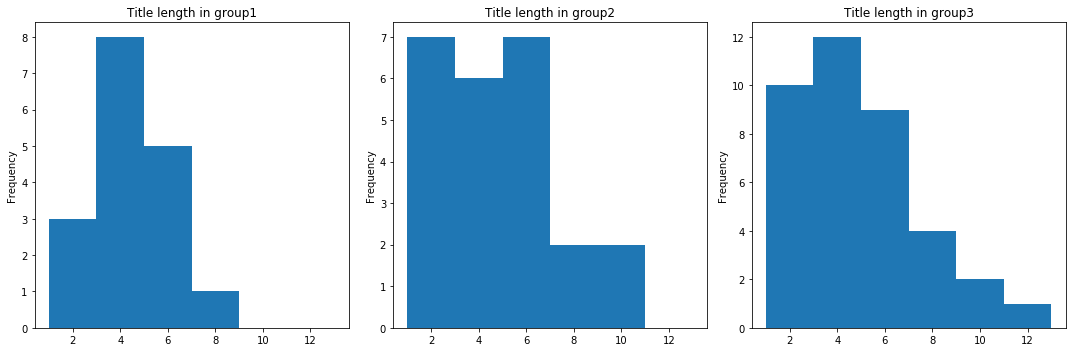

In [17]:
#plot the title length for each group
fig, axes = plt.subplots(1, 3)
# plot counter
for c in [1,2,3]:
    df[df['Group']==c]['title_len']
    df[df['Group']==c]['title_len'].plot(kind='hist', ax=axes[c-1], bins =6, title=f"Title length in group{c}",
                                figsize=(15,5), range=[1,13])
    plt.tight_layout()
plt.show()

We observe that for each group, title length is mostly concentrated in the range 2-6. We also observe that for group 2 and group 3, there are plenty of books with length=2. In contrast, there are very few books in group 1 with this length. Another visible fact is group 3 is the only group having books with more than 10 words. This kind of makes sense because older kids are more capable of reading long and complex titles.

We can also ask the following question: is this true that descriptions for books belonging to older groups tend to be longer than the ones for younger kids? This kind of makes sense because the stories in former ones are typically more complicated and hence it takes more effort to describe them. We can easily check this hypothesis by investing some simple statistics.

In [18]:
df['description_len']=df['description'].apply(lambda x: len(x))

In [19]:
df.groupby('Group')['description_len'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
1,17.0,322.294118,95.823252,182.0,240.0,309.0,361.00,528.0
2,24.0,386.291667,107.662710,216.0,309.5,363.5,443.75,582.0
3,38.0,417.973684,79.775186,245.0,360.5,427.5,457.75,627.0


It is visibly clear that the above speculation seems to be supported by the data. Hence, it might be useful to include this information into our models.

Next, we want to tockenize the title and the description for each book.

In [20]:
#a function to tockenize a text
def tockenize(text):
    tockenized_text_1= re.split('\W+', text)
    tockenized_text=[word for word in tockenized_text_1 if len(word)>1]
    return tockenized_text

In [21]:
#apply the tockenize function to create new columns 
df['tockenized_title']=df['title'].apply(lambda x: tockenize(x))
df['tockenized_description']=df['description'].apply(lambda x: tockenize(x))
df.sample(5)

,title,description,Group,count_punct,title_clean,description_clean,title_len,description_len,tockenized_title,tockenized_description
53,the mitten by jan brettthe mitten \nby jan brett,the story is a ukranian folk tale about the bo...,3,0,the mitten by jan brettthe mitten \nby jan brett,the story is a ukranian folk tale about the bo...,9,306,"[the, mitten, by, jan, brettthe, mitten, by, j...","[the, story, is, ukranian, folk, tale, about, ..."
43,amelia bedelia,amelia bedelia is a series of books about a ma...,3,0,amelia bedelia,amelia bedelia is a series of books about a ma...,2,331,"[amelia, bedelia]","[amelia, bedelia, is, series, of, books, about..."
2,"brown bear, brown bear what do you see?",a parade of animals of different colors will d...,1,1,brown bear brown bear what do you see,a parade of animals of different colors will d...,8,222,"[brown, bear, brown, bear, what, do, you, see]","[parade, of, animals, of, different, colors, w..."
59,eloise: a book for precocious grown ups,eloise is a 6-year-old precocious girl who liv...,3,0,eloise a book for precocious grown ups,eloise is a 6yearold precocious girl who lives...,7,434,"[eloise, book, for, precocious, grown, ups]","[eloise, is, year, old, precocious, girl, who,..."
41,"alexander and the terrible, \nhorrible, no goo...",this book helps your child understand what it ...,3,0,alexander and the terrible \nhorrible no good ...,this book helps your child understand what it ...,10,436,"[alexander, and, the, terrible, horrible, no, ...","[this, book, helps, your, child, understand, w..."


We can also filter out irrelevant information by removing stopwords. Let's take a quick look at the list of English stopwords.

In [22]:
import nltk

stopwords = nltk.corpus.stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Using this list, we can filter out the more relevant words.

In [23]:
#remove stopwords
def no_stopwords(text):
    no_stopwords_text=[char for char in text if char not in stopwords]
    return no_stopwords_text

In [24]:
df['no_stopwords_title']=df['tockenized_title'].apply(lambda x: no_stopwords(x))
df['no_stopwords_description']=df['tockenized_description'].apply(lambda x: no_stopwords(x))
df.sample(3)

,title,description,Group,count_punct,title_clean,description_clean,title_len,description_len,tockenized_title,tockenized_description,no_stopwords_title,no_stopwords_description
59,eloise: a book for precocious grown ups,eloise is a 6-year-old precocious girl who liv...,3,0,eloise a book for precocious grown ups,eloise is a 6yearold precocious girl who lives...,7,434,"[eloise, book, for, precocious, grown, ups]","[eloise, is, year, old, precocious, girl, who,...","[eloise, book, precocious, grown, ups]","[eloise, year, old, precocious, girl, lives, p..."
17,corduroy,acclaimed as one of school library journal’s “...,2,0,corduroy,acclaimed as one of school library journal’s “...,1,328,[corduroy],"[acclaimed, as, one, of, school, library, jour...",[corduroy],"[acclaimed, one, school, library, journal, top..."
68,the borrowers,the borrowers is a series of classic books abo...,3,0,the borrowers,the borrowers is a series of classic books abo...,2,384,"[the, borrowers]","[the, borrowers, is, series, of, classic, book...",[borrowers],"[borrowers, series, classic, books, clock, fam..."


Next, we can simplify our tockenized words by using stemming and/or lemmatizing. Very roughly speaking, while stemming is based on rule-based algorithms to chop-offs irrelevant characters, lemmatizing is based on more complicated analysis of words. For more details about the difference between the two approaches, we refer to the following website

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

Both stemming and lemmatizing is available in the nltk library. 



In [25]:
import nltk
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()

In [26]:
#functions to stem and lemmatize a list of words

def stem(text):
    stemmed_text=[ps.stem(word) for word in text]
    return stemmed_text
def lemmatize(text):
    lemmatized_text=[wn.lemmatize(word) for word in text]
    return lemmatized_text
    

In [27]:
#stem and lemmatize our bag of words
df['stemmed_title']=df['no_stopwords_title'].apply(lambda x: stem(x))
df['stemmed_description']=df['no_stopwords_description'].apply(lambda x: stem(x))
df['lemmatized_description']=df['no_stopwords_description'].apply(lambda x: lemmatize(x))
df.head(2)

,title,description,Group,count_punct,title_clean,description_clean,title_len,description_len,tockenized_title,tockenized_description,no_stopwords_title,no_stopwords_description,stemmed_title,stemmed_description,lemmatized_description
0,the very hungry caterpillar,it follows a caterpillar from being hatched fr...,1,0,the very hungry caterpillar,it follows a caterpillar from being hatched fr...,4,182,"[the, very, hungry, caterpillar]","[it, follows, caterpillar, from, being, hatche...","[hungry, caterpillar]","[follows, caterpillar, hatched, egg, eating, w...","[hungri, caterpillar]","[follow, caterpillar, hatch, egg, eat, way, di...","[follows, caterpillar, hatched, egg, eating, w..."
1,chicka chicka boom boom,this book is the baby’s fanciful introduction ...,1,0,chicka chicka boom boom,this book is the baby’s fanciful introduction ...,4,316,"[chicka, chicka, boom, boom]","[this, book, is, the, baby, fanciful, introduc...","[chicka, chicka, boom, boom]","[book, baby, fanciful, introduction, abc, char...","[chicka, chicka, boom, boom]","[book, babi, fanci, introduct, abc, charact, b...","[book, baby, fanciful, introduction, abc, char..."


Since the author's descriptions use rather common words, we suspect that there is not too much differnce between the
no_stopwords_description and its lemmatized version. We can check this by using the following code.

In [28]:
#compute the difference between no_stopwords_description and its lemmatized version
test_df=df.copy()[['no_stopwords_description', 'lemmatized_description']]
my_list=[]
for i in range(len(test_df)):
    difference_i=sum([test_df['no_stopwords_description'][i][j] != test_df['lemmatized_description'][i][j]
                    for j in range(len(test_df['no_stopwords_description'][i]))])
    my_list.append(difference_i)
test_df['count_difference']=my_list    
test_df['percentage_difference']=test_df['count_difference']/df['no_stopwords_description'].apply(lambda x: len(x))

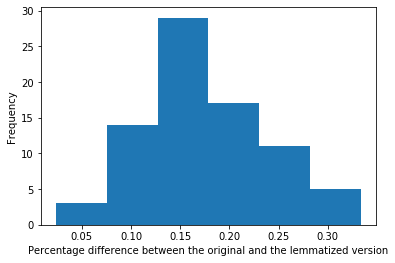

In [29]:
test_df['percentage_difference'].plot(kind='hist', bins=6)
plt.xlabel('Percentage difference between the original and the lemmatized version')
plt.show()

We see that the percentage difference is concentrated in the range 15-25 percent. It seems to us that such difference
is significant enough to distinguish the original text and its lemmatized version. Consequently, we will keep the lemmatized version in our dataset.

We can ask the same question about the title and its lemmatized version. 

In [30]:
#compute the difference between no_stopwords_description and its lemmatized version
test_df_1=df.copy()[['no_stopwords_title', 'Group']]
test_df_1['lemmatized_title']=df['no_stopwords_title'].apply(lambda x: lemmatize(x))
my_list_1=[]
for i in range(len(test_df_1)):
    difference_i=sum([test_df_1['no_stopwords_title'][i][j] != test_df_1['lemmatized_title'][i][j]
                    for j in range(len(test_df_1['no_stopwords_title'][i]))])
    my_list_1.append(difference_i)
test_df_1['count_difference']=my_list_1
test_df_1['count_difference'].value_counts()

0    58
1    17
2     3
3     1
Name: count_difference, dtype: int64

It seems that there is not much difference between the title and its lemmatized one. Therefore, we will not include it into our dataframe.

In our previous discussion, it is discovered that the lengths of the descriptions provide meaningful information about aged-groups. We wonder whether the same is true for the version with no_stopwords (note that the length of the no_stopword version is the same as its stemmed/lemmatized version.) Again, we can use descriptive statistics to solve this problem. 

In [31]:
test_df_2=df.copy()[['Group']]
test_df_2['no_stopwords_description_len']=df['no_stopwords_description'].apply(lambda x: len(x))

In [32]:
test_df_2.groupby('Group')['no_stopwords_description_len'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
1,17.0,28.411765,9.124547,14.0,23.00,26.0,36.00,48.0
2,24.0,37.083333,10.133529,21.0,29.50,36.0,45.25,54.0
3,38.0,39.131579,8.200762,22.0,32.25,38.5,45.00,60.0


The difference between group 1 and the other groups seems to be significant. However, for group 2 and group 3, this feature is rather similar. Therefore, we will not use this feature in our model because the corresponding description_len feature is similar but more distinguishable.   

Next, we will quantify the raw information that we obtained so far. To do so, we will use the Countvectorize function 
in skit-learn.

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


First we will create a document-term data for the title.

In [34]:
#create a document-term matrix for the title data
count_vectorize_title= CountVectorizer()
X_counts_title = count_vectorize_title.fit_transform(df['stemmed_title'].apply(lambda x: " ".join(x)))
df_title=pd.DataFrame(X_counts_title.toarray(), columns=count_vectorize_title.get_feature_names())


We can also create a TF-IDF version of the title.

In [35]:
#create a document-term matrix for the title data
tfidf_vectorize_title= TfidfVectorizer()
X_tfidf_title = tfidf_vectorize_title.fit_transform(df['stemmed_title'].apply(lambda x: " ".join(x)))
df_title_tfidf=pd.DataFrame(X_counts_title.toarray(), columns=tfidf_vectorize_title.get_feature_names())


Next, we will use the stemmed_description feature to create a document-term data.

In [36]:
#document-term data from the stemmed_description data
cv_stemmed_description= CountVectorizer()
X_stemmed_description = cv_stemmed_description.fit_transform(df['stemmed_description'].apply(lambda x: " ".join(x)))
df_stemmed_description=pd.DataFrame(X_stemmed_description.toarray(), columns=cv_stemmed_description.get_feature_names())

We will also create a tfidf version.

In [37]:
cv_tfidf_description=TfidfVectorizer()
X_tfidf_description=cv_tfidf_description.fit_transform(df['stemmed_description'].apply(lambda x: " ".join(x)))
df_tfidf_description= pd.DataFrame(X_tfidf_description.toarray(), columns=cv_tfidf_description.get_feature_names())

We plan to comare our models with respect to the stemmed and lemmatized data so we will create a document-term matrix
for the lemmatized description as well. 

In [38]:
#document-term data from the lemmatizeddescription data
cv_lemma_description= CountVectorizer()
X_lemma_description = cv_lemma_description.fit_transform(df['lemmatized_description'].apply(lambda x: " ".join(x)))
df_lemmatized_description=pd.DataFrame(X_lemma_description.toarray(), columns=cv_lemma_description.get_feature_names())

We will create a data frame containing the stemmed_description datafarme together with the following features: description_len, title_len,count_punct, and group.

In [39]:
stemmed_df=pd.concat([df[['description_len',
                          'title_len', 'Group', 'count_punct']], df_stemmed_description, df_title], axis=1)

Similarly, we will create a data frame with the lemmatitized_description dataframe together with the following features: description_len, title_len, count_punct, and group. 

In [40]:
lemmatized_df=pd.concat([df[['description_len', 'title_len', 
                             'Group', 'count_punct']], df_lemmatized_description, df_title], axis=1)

Finally, we can also create a DF-TIF version.

In [41]:
df_tfidf=pd.concat([df[['description_len', 'title_len', 
                             'Group', 'count_punct']], df_tfidf_description, df_title], axis=1)

Before we develop some machine learning models for classifcation, it would be interesting to see how often the word "read" appears in the description. 

In [42]:
#count the number of times that the word "read" appears in the description
read=df.copy()[['Group']]
my_list=[0]*len(read)
for i in range(len(read)):
    my_list[i]=sum(['read' == df['stemmed_description'][i][j] for j in range(len(df['stemmed_description'][i]))])
read['read_count']=my_list    


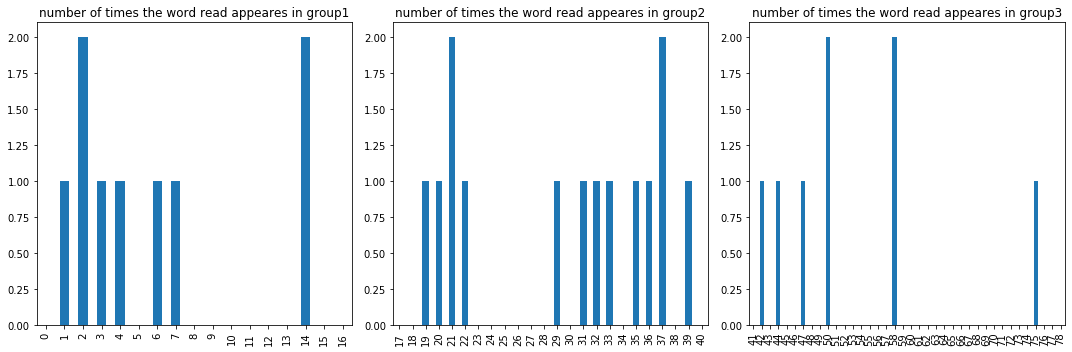

In [43]:
#bar plot of the number of times the word read appeared in the description
fig, axes = plt.subplots(1, 3)
# plot counter
for c in [1,2,3]:
    read[read['Group']==c]['read_count'].plot(kind='bar', ax=axes[c-1], 
                                              title=f"number of times the word read appeares in group{c}",
                                               figsize=(15,5))
    plt.tight_layout()
plt.show()

We can also use descriptive statistics to answer this question.

In [44]:
read.groupby('Group')['read_count'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
1,17.0,0.529412,0.717430,0.0,0.0,0.0,1.0,2.0
2,24.0,0.583333,0.653863,0.0,0.0,0.5,1.0,2.0
3,38.0,0.210526,0.528020,0.0,0.0,0.0,0.0,2.0


It is clear that the word "read" appears more often in the younger groups. Perhaps, one reason is that the descriptions for older aged-group are mostly to summarize the story (rather than describe what readers can do with the books.)

We can also investigate the keyword 'baby' appeared in the description.

In [45]:
baby=df.copy()[['Group']]
my_list_baby=[0]*len(baby)
for i in range(len(baby)):
    my_list_baby[i]=sum(['baby' == df['lemmatized_description'][i][j] 
                         for j in range(len(df['lemmatized_description'][i]))])
baby['baby_count']=my_list_baby

In [46]:
data=pd.DataFrame(baby.groupby('Group')['baby_count'].value_counts())
data

baby_count
Group baby_count            
1     1                    6
      2                    6
      0                    3
      3                    2
2     0                   21
      1                    3
3     0                   37
      1                    1

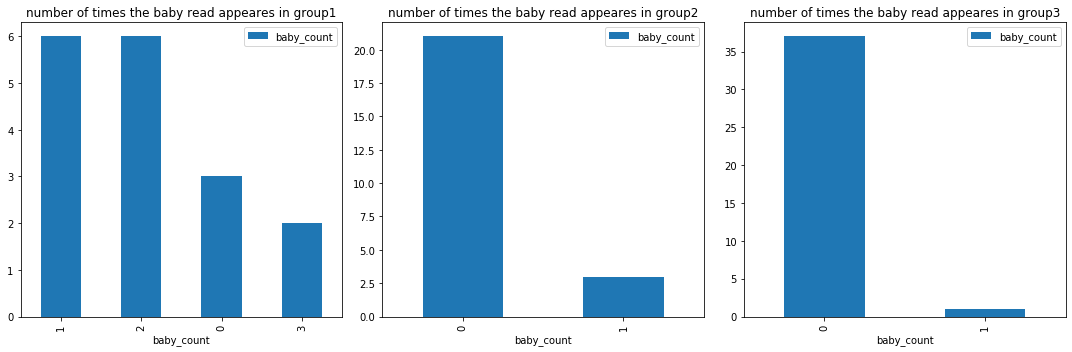

In [47]:
#bar plot of the number of times the word baby appeared in the description
fig, axes = plt.subplots(1, 3)
# plot counter
for c in [1,2,3]:
    data.loc[c].plot(kind='bar', ax=axes[c-1], 
                        title=f"number of times the baby read appeares in group{c}",
                        figsize=(15,5))
    plt.tight_layout()
plt.show()

We see that the word baby mostly appears in group 1 (0-2 years old kids). It is kind of cheating to include this word
in our model. Therefore, we will drop the column 'baby' from our datasets.

In [48]:
#drop the baby feature from the datasets.
lemmatized_df.drop('baby', axis=1, inplace=True)
stemmed_df.drop('babi', axis=1, inplace=True)
df_tfidf.drop('babi', axis=1, inplace=True)

Similarly, we can also study how often the word 'kid' appears in the description.

In [49]:
kid=df.copy()[['Group']]
my_list_kid=[0]*len(baby)
for i in range(len(kid)):
    my_list_kid[i]=sum(['kid' == df['stemmed_description'][i][j] 
                         for j in range(len(df['stemmed_description'][i]))])
kid['kid_count']=my_list_kid
data_kid=pd.DataFrame(kid.groupby('Group')['kid_count'].value_counts())
data_kid

kid_count
Group kid_count           
1     0                 16
      1                  1
2     0                 17
      1                  7
3     0                 29
      1                  9

We see that the word 'kid' only appears once in group 1. However, it appears in about 1/3 descriptions for group 2 and in about 1/4 descriptions for group 3. Since it does not entirely biased towards a particular group, we keep it in the data set.

We are also curious about what words appeared most often in the title and the descriptions. Let explore the data and see.

In [50]:
#ten most popular words in the description
df_lemmatized_description.sum().sort_values(ascending=False).iloc[:10]

book            105
child            50
story            50
illustration     37
baby             28
make             25
read             23
fun              21
animal           21
little           20
dtype: int64

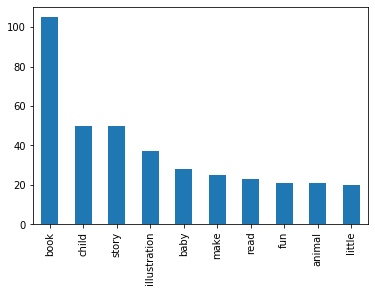

In [51]:
#ten most popular words in the description.
df_lemmatized_description.sum().sort_values(ascending=False).iloc[:10].plot(kind='bar')

While it is expected that words like "book", "story", "read" would appear rather often (after all, the article is a book review!), it is still intersting to see that "illustration", "fun", "animal" make it to the list! 

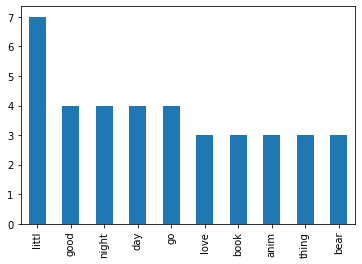

In [52]:
#10 most popular words in the title
df_title.sum().sort_values(ascending=False).iloc[:10].plot(kind='bar')

In [53]:
df_title.sum().sort_values(ascending=False).iloc[:10].index

Index(['littl', 'good', 'night', 'day', 'go', 'love', 'book', 'anim', 'thing',
       'bear'],
      dtype='object')

It seems tht the book titles are rather diverse. 

# Part 2: Train and Evaluate Machine Learning Models

We note we have multiple classes in our problem.

To get some feeling about the problem, it is perhaps a good to try a simple model that could solves mutliclass classification problem such as decision tree. 

# Part 2.1: Decision tree models.

In [54]:
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [55]:
#First, select the feature for our model
X_stemmed=stemmed_df.copy().drop(['Group'], axis=1)
y_stemmed=stemmed_df['Group']
X_train, X_test, y_train, y_test = train_test_split(X_stemmed, y_stemmed, test_size=0.4, random_state=42)
#train a tree model using the training set
tree_model_0 = DecisionTreeClassifier(max_depth = 5).fit(X_train, y_train) 

In [56]:
#use the above model to predict on the test set
train_prediction_stemmed=tree_model_0.predict(X_train)

In [57]:
#confussion metrics for the training set
sklearn.metrics.confusion_matrix(y_train, train_prediction_stemmed)

array([[10,  0,  0],
       [ 1, 13,  0],
       [ 0,  0, 23]])

In [58]:
#we can also get a more complete statistical summary of the model
print(sklearn.metrics.classification_report(y_train, train_prediction_stemmed))

              precision    recall  f1-score   support

           1       0.91      1.00      0.95        10
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00        23

    accuracy                           0.98        47
   macro avg       0.97      0.98      0.97        47
weighted avg       0.98      0.98      0.98        47



We see that this tree model performs pretty well on the training set. Let us evaluate on the test set as well.

In [59]:
#Let predict and evaluate our model on the test set.
test_prediction_stemmed=tree_model_0.predict(X_test)
sklearn.metrics.confusion_matrix(y_test, test_prediction_stemmed)

array([[2, 1, 4],
       [3, 1, 6],
       [4, 3, 8]])

In [60]:
#scores of our model
print(sklearn.metrics.classification_report(y_test, test_prediction_stemmed))

              precision    recall  f1-score   support

           1       0.22      0.29      0.25         7
           2       0.20      0.10      0.13        10
           3       0.44      0.53      0.48        15

    accuracy                           0.34        32
   macro avg       0.29      0.31      0.29        32
weighted avg       0.32      0.34      0.32        32



This models performce rather poorly on the test set, especially for group 2. Before we try to find a better model, let take a look at how the above decision tree model works.

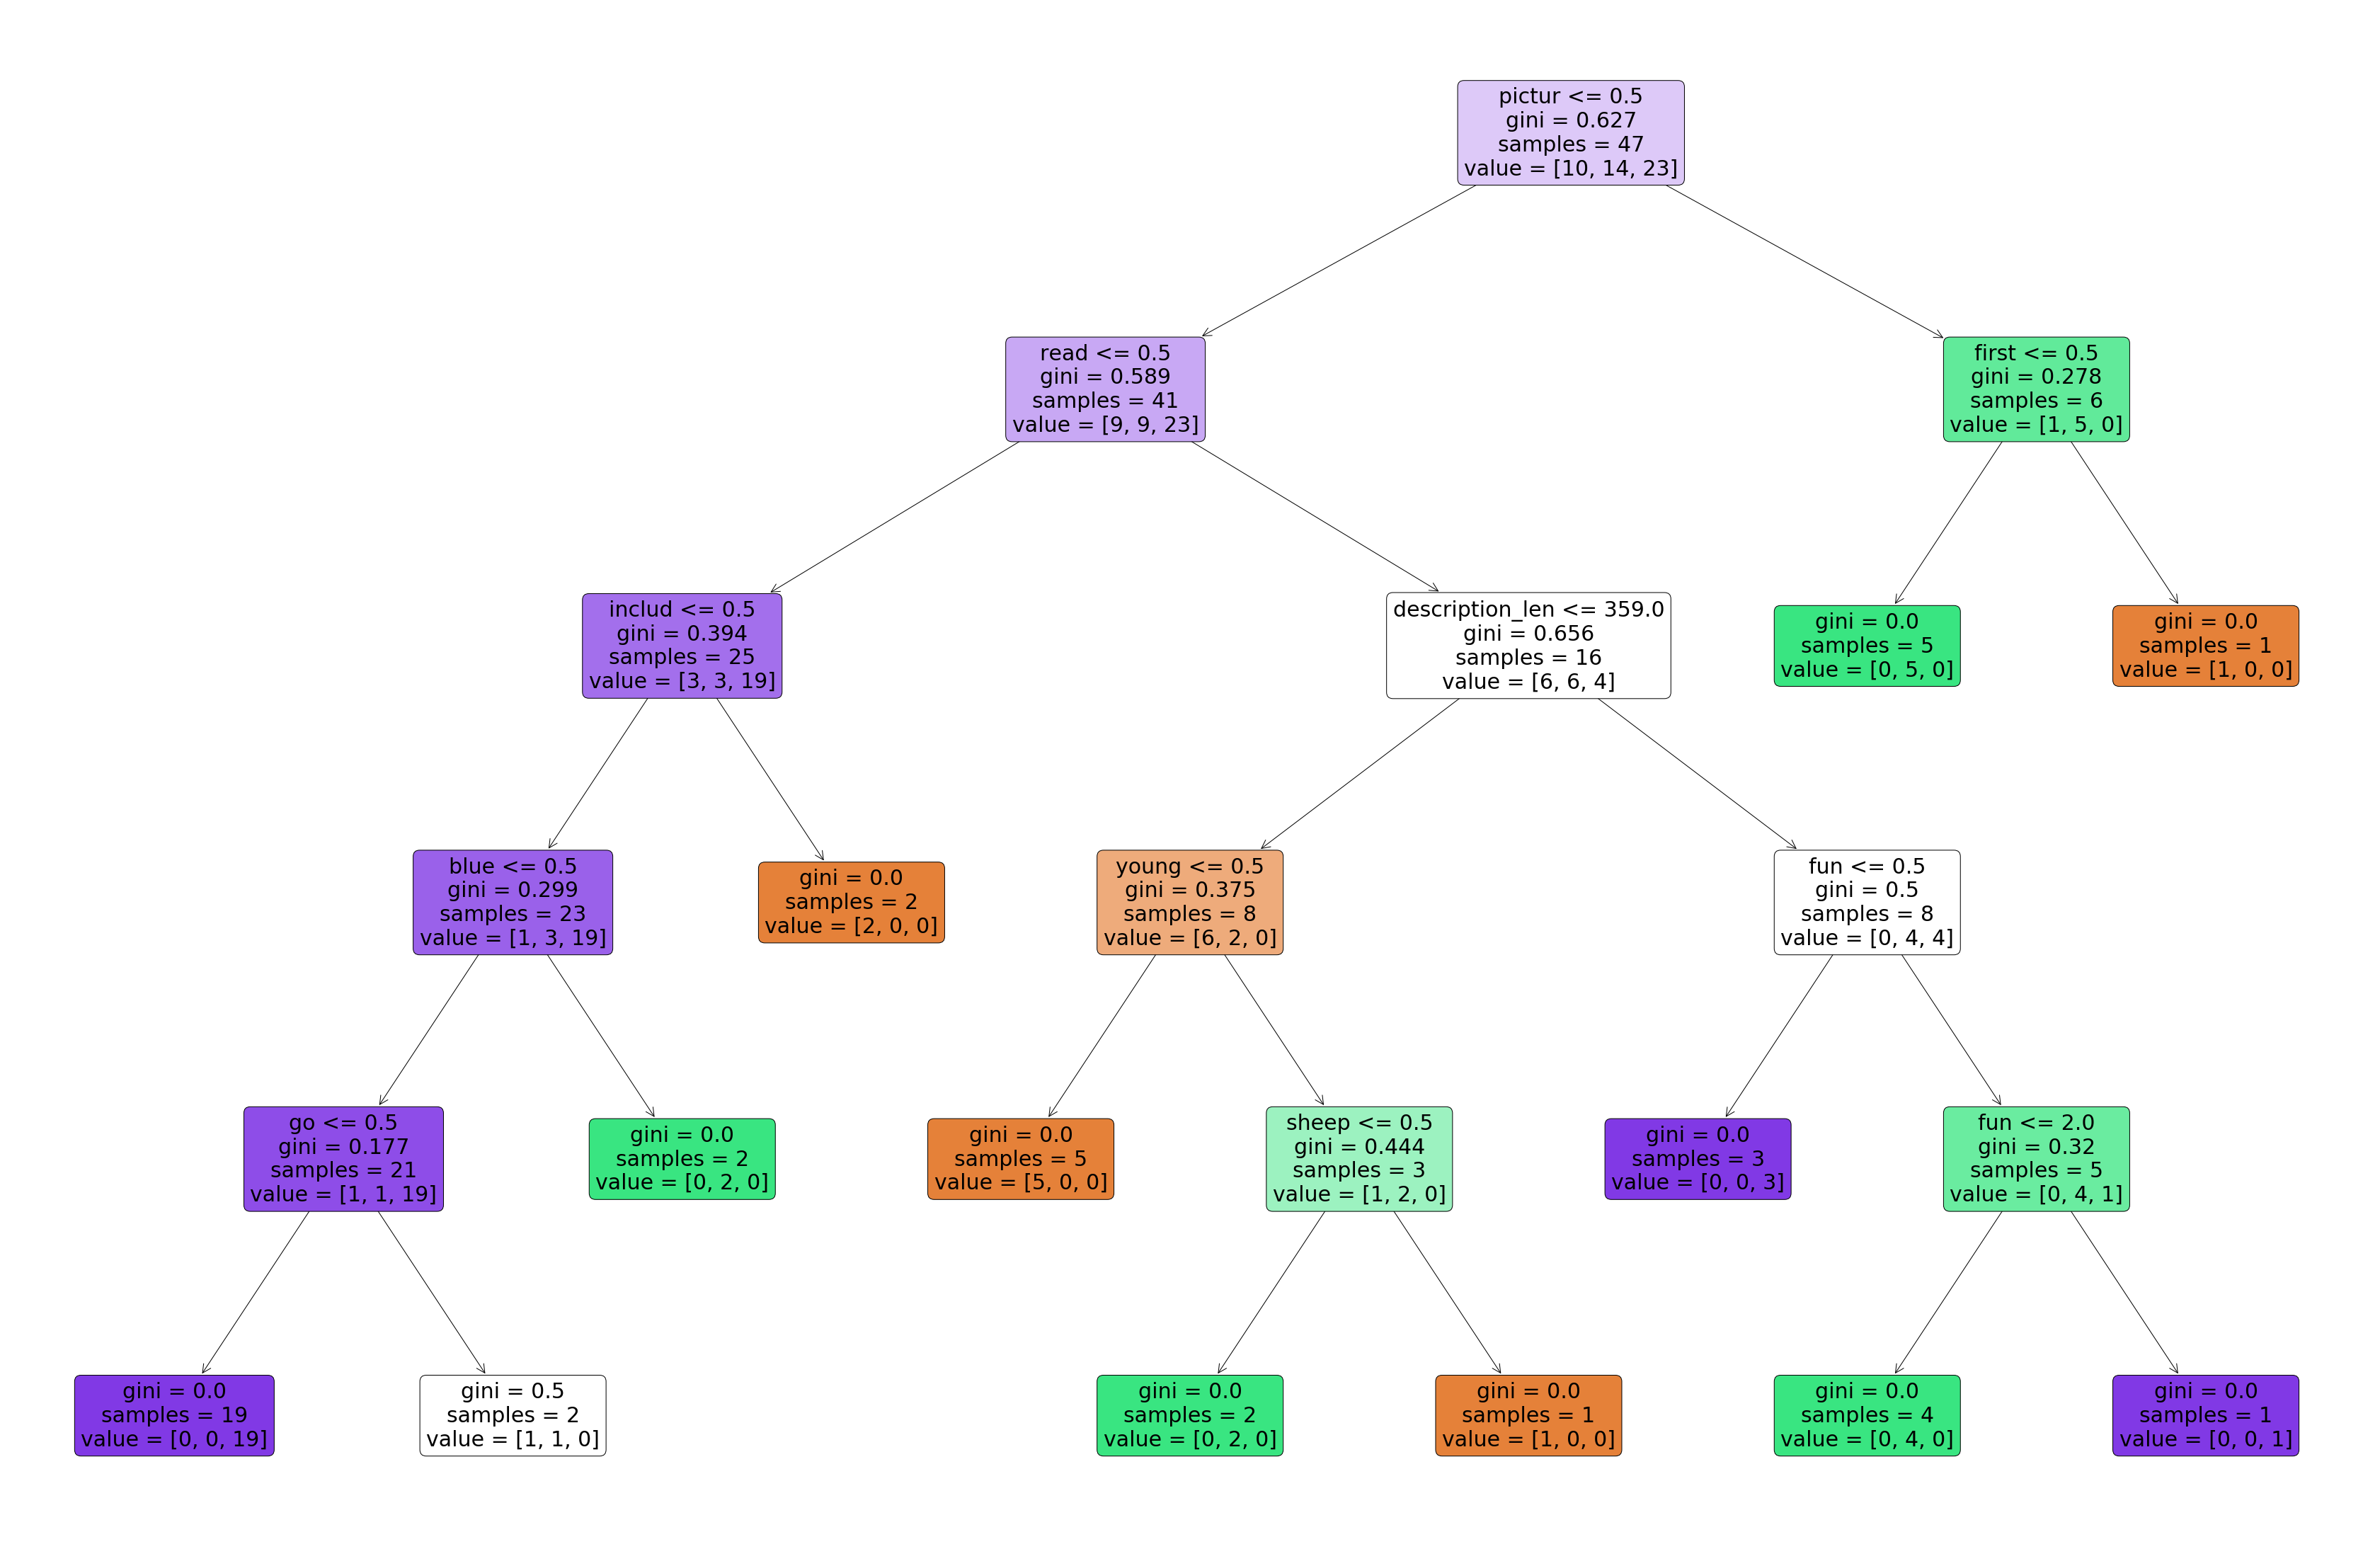

In [61]:
from sklearn.tree import plot_tree
plt.figure(figsize=(60,40))
a = plot_tree(tree_model_0, 
              feature_names=X_stemmed.columns, 
              #class_names=y.columns, 
              filled=True, 
              rounded=True, 
              fontsize=30)
plt.show()

It is pleasant to observe that one of the first features used to split the tree is the description_len as we expect that the description length is a distinguished feature amongst different groups.

In [62]:
#First, select the feature for our model
#X=pd.concat([df[['description_len', 'title_len', 
                             #'Group', 'count_punct']], df_lemmatized_description], axis=1)
X_lemmatized=df_lemmatized_description.copy().drop(['sparse'], axis=1)
X_lemmatized['sparse_changed']=df_lemmatized_description['sparse']
y_lemmatized=df['Group']
X_train_lm, X_test_lm, y_train_lm, y_test_lm= train_test_split(X_lemmatized, y_lemmatized, 
                                                    test_size=0.4, random_state=42)
#train a tree model using the training set on the lemmatized dataset
tree_model_lm_0 = DecisionTreeClassifier(max_depth = 5).fit(X_train_lm, y_train_lm)

In [63]:
#predictions on the train and test set
tree_prediction_train_lm= tree_model_lm_0.predict(X_train_lm)
tree_prediction_test_lm=tree_model_lm_0.predict(X_test_lm)

In [64]:
#confussion metrics for the training set
print(sklearn.metrics.confusion_matrix(y_train_lm, tree_prediction_train_lm))
print(sklearn.metrics.classification_report(y_train_lm, tree_prediction_train_lm))

[[ 9  0  1]
 [ 0 12  2]
 [ 0  0 23]]
              precision    recall  f1-score   support

           1       1.00      0.90      0.95        10
           2       1.00      0.86      0.92        14
           3       0.88      1.00      0.94        23

    accuracy                           0.94        47
   macro avg       0.96      0.92      0.94        47
weighted avg       0.94      0.94      0.94        47



This model performs pretty well on the traing set. Let us evaluate it on the test set as well. 

In [65]:
#confussion metrics for the test set
print(sklearn.metrics.confusion_matrix(y_test_lm, tree_prediction_test_lm))
print(sklearn.metrics.classification_report(y_test_lm, tree_prediction_test_lm))

[[ 3  2  2]
 [ 0  0 10]
 [ 0  4 11]]
              precision    recall  f1-score   support

           1       1.00      0.43      0.60         7
           2       0.00      0.00      0.00        10
           3       0.48      0.73      0.58        15

    accuracy                           0.44        32
   macro avg       0.49      0.39      0.39        32
weighted avg       0.44      0.44      0.40        32



As above, this tree model runs into the same problem of overfitting. Finally, let train our model on the tf-idf data frame.

In [66]:
X_tfidf=df_tfidf.copy().drop(['Group'], axis=1)
y_tfidf=df['Group']
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_tfidf, test_size=0.4, random_state=42)
#train a tree model using the training set
tree_model_tfidf = DecisionTreeClassifier(max_depth = 5).fit(X_train_tfidf, y_train_tfidf) 
train_prediction_tfidf=tree_model_tfidf.predict(X_train_tfidf)
test_prediction_tfidf=tree_model_tfidf.predict(X_test_tfidf)

In [67]:
#confussion matrix for the training set
print(sklearn.metrics.confusion_matrix(y_train_tfidf, train_prediction_tfidf))
print(sklearn.metrics.classification_report(y_train_tfidf, train_prediction_tfidf))

[[ 4  3  3]
 [ 0 13  1]
 [ 0  1 22]]
              precision    recall  f1-score   support

           1       1.00      0.40      0.57        10
           2       0.76      0.93      0.84        14
           3       0.85      0.96      0.90        23

    accuracy                           0.83        47
   macro avg       0.87      0.76      0.77        47
weighted avg       0.85      0.83      0.81        47



In [68]:
#confussion matrix for the test set
print(sklearn.metrics.confusion_matrix(y_test_tfidf, test_prediction_tfidf))
print(sklearn.metrics.classification_report(y_test_tfidf, test_prediction_tfidf))

[[ 1  0  6]
 [ 0  4  6]
 [ 0  4 11]]
              precision    recall  f1-score   support

           1       1.00      0.14      0.25         7
           2       0.50      0.40      0.44        10
           3       0.48      0.73      0.58        15

    accuracy                           0.50        32
   macro avg       0.66      0.43      0.42        32
weighted avg       0.60      0.50      0.46        32



As other models, this model does not perform well on group 1 and group 2. 

# Part 2.2: Logistic regression

In [69]:
from sklearn.linear_model import LogisticRegression

In [70]:
#train a logistic regression model and use it to predict using the stemmed data frame.
stemmed_logit=LogisticRegression(max_iter=1000)
stemmed_logit.fit(X_train, y_train)
logit_stemmed_train_prediction=stemmed_logit.predict(X_train)
logit_stemmed_test_prediction=stemmed_logit.predict(X_test)

In [71]:
#evaluate on the training set

sklearn.metrics.confusion_matrix(y_train, logit_stemmed_train_prediction)

array([[10,  0,  0],
       [ 0, 14,  0],
       [ 0,  0, 23]])

This model performs perfectly on the training set. Let us take a look at the performance on the test set.

In [72]:
# evaluation on the test set
sklearn.metrics.confusion_matrix(y_test, logit_stemmed_test_prediction)

array([[ 4,  1,  2],
       [ 3,  0,  7],
       [ 1,  0, 14]])

We see that this model's performance is pretty good on group 1 and group 3. However, it is not good on group 2. We can also test our model on the lemmatized data set.

In [73]:
lemmatized_logit=LogisticRegression()
lemmatized_logit.fit(X_train_lm, y_train_lm)
lm_train_prediction=lemmatized_logit.predict(X_train_lm)
lm_test_prediction =lemmatized_logit.predict(X_test_lm)

In [74]:
#confusion matrix for the training set
sklearn.metrics.confusion_matrix(y_train_lm, lm_train_prediction)

array([[10,  0,  0],
       [ 0, 14,  0],
       [ 0,  0, 23]])

In [75]:
sklearn.metrics.confusion_matrix(y_test_lm, lm_test_prediction)

array([[ 3,  1,  3],
       [ 0,  1,  9],
       [ 1,  2, 12]])

As before, we see that this model overfits the data. Let us train a similar model on the tfidf version.

In [76]:
#train a logistic regression model and use it to predict using the stemmed data frame.
tfidf_logit=LogisticRegression(max_iter=1000)
tfidf_logit.fit(X_train_tfidf, y_train_tfidf)
logit_tfidf_train_prediction=stemmed_logit.predict(X_train_tfidf)
logit_tfidf_test_prediction=stemmed_logit.predict(X_test_tfidf)

In [77]:
sklearn.metrics.confusion_matrix(y_train_tfidf, logit_tfidf_train_prediction)

array([[ 4,  0,  6],
       [ 2,  0, 12],
       [ 0,  0, 23]])

In [78]:
print(sklearn.metrics.confusion_matrix(y_test_tfidf, logit_tfidf_test_prediction))
print(sklearn.metrics.classification_report(y_test_tfidf, logit_tfidf_test_prediction))

[[ 3  0  4]
 [ 0  0 10]
 [ 0  0 15]]
              precision    recall  f1-score   support

           1       1.00      0.43      0.60         7
           2       0.00      0.00      0.00        10
           3       0.52      1.00      0.68        15

    accuracy                           0.56        32
   macro avg       0.51      0.48      0.43        32
weighted avg       0.46      0.56      0.45        32



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Again, this model seems to overfit the data.

One thing we can try to avoid overfitting is that we can use regularized logistics regression model. Let try this idea on the stemmed dataset. 

In [83]:
ridge=LogisticRegression(C=10, penalty='l2', max_iter=10000 )
ridge.fit(X_train, y_train)
ridge_train_prediction=ridge.predict(X_train)
ridge_test_prediction=ridge.predict(X_test)


In [84]:
#confussion matrix for the training set
sklearn.metrics.confusion_matrix(y_train, ridge_train_prediction)

array([[10,  0,  0],
       [ 0, 14,  0],
       [ 0,  0, 23]])

In [85]:
print(sklearn.metrics.confusion_matrix(y_test, ridge_test_prediction))
print(sklearn.metrics.classification_report(y_test, ridge_test_prediction))

[[ 4  1  2]
 [ 3  0  7]
 [ 0  1 14]]
              precision    recall  f1-score   support

           1       0.57      0.57      0.57         7
           2       0.00      0.00      0.00        10
           3       0.61      0.93      0.74        15

    accuracy                           0.56        32
   macro avg       0.39      0.50      0.44        32
weighted avg       0.41      0.56      0.47        32



This is argurably the best model so far.

# Part 2.3: Random Forest Models.

In [86]:
#build a random forest classifier on the stemmed data
stemmed_rf_model_0 = RandomForestClassifier(n_estimators=100).fit(X_train, y_train) 

In [87]:
#use the above model to make predictions on the traning set and the test set

rf_train_prediction_0=stemmed_rf_model_0.predict(X_train)
rf_test_prediction_0=stemmed_rf_model_0.predict(X_test)

In [88]:
#compute the confussion matrix for the training set
sklearn.metrics.confusion_matrix(y_train, rf_train_prediction_0)

array([[10,  0,  0],
       [ 0, 14,  0],
       [ 0,  0, 23]])

In [89]:
print(sklearn.metrics.classification_report(y_train, rf_train_prediction_0))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        23

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47



It appears this random forrest model performs perfectly on the training set. This might be a sign of overfitting. Let us evaluate this model on the test set to see what happens.

In [90]:
#confussion matrix on the test set

sklearn.metrics.confusion_matrix(y_test, rf_test_prediction_0)

array([[ 1,  0,  6],
       [ 0,  0, 10],
       [ 0,  0, 15]])

Clearly, this model overfits the training set. We hope to overcome overfitting by putting some contrains on the trees. For example, we can restrict that the max_depth of each tree in the forest is 5.

In [91]:
#build a random forest classifier on the stemmed data where max_depth=5
rf_model_1 = RandomForestClassifier(max_depth=10, n_estimators=100).fit(X_train, y_train) 
rf_train_prediction_1=rf_model_1.predict(X_train)
rf_test_prediction_1=rf_model_1.predict(X_test)

In [92]:
#confussion matrix for the traing set
sklearn.metrics.confusion_matrix(y_train, rf_train_prediction_1)

array([[10,  0,  0],
       [ 0, 14,  0],
       [ 0,  0, 23]])

Again, this model performs very well on the training set. Let us evaluate it on the test set.

In [93]:
sklearn.metrics.confusion_matrix(y_test, rf_test_prediction_1)

array([[ 1,  0,  6],
       [ 0,  0, 10],
       [ 0,  0, 15]])

Unfortunately, it is still overfitting. Let us use other hyperparameters.

In [94]:
#we can also change the number of trees to see what happens.
rf_model_2 = RandomForestClassifier(max_depth=10, n_estimators=70).fit(X_train, y_train) 
rf_train_prediction_2=rf_model_2.predict(X_train)
rf_test_prediction_2=rf_model_2.predict(X_test)
print(sklearn.metrics.confusion_matrix(y_train, rf_train_prediction_2))
print(sklearn.metrics.confusion_matrix(y_test, rf_test_prediction_2))

[[10  0  0]
 [ 0 14  0]
 [ 0  0 23]]
[[ 1  0  6]
 [ 0  0 10]
 [ 0  0 15]]


Still, it does not perform well on group 1 and group 2. 

In the above approach, we change the number of trees by hand. We can also use a Gridsearch to find a better hyperparameters.

In [95]:
from sklearn.model_selection import GridSearchCV

In [96]:
param = {'n_estimators': [50, 150, 300],
        'max_depth': [5, 10, 20, None]}

gs = GridSearchCV(RandomForestClassifier(), param, cv=5, n_jobs=-1)
gs_fit = gs.fit(X_train, y_train)
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:2]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.123271,0.002852,0.023135,0.001184,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.5,0.5,0.555556,0.444444,0.444444,0.488889,0.041574,1
1,0.352351,0.022359,0.047731,0.006795,5,150,"{'max_depth': 5, 'n_estimators': 150}",0.5,0.5,0.555556,0.444444,0.444444,0.488889,0.041574,1


The gridsearch suggests that we can use 50 trees in our random forest and set the max_length to be 5.

In [97]:
#train a random forest model with the "best" hyperparameters
rf_model_2 = RandomForestClassifier(max_depth=50, n_estimators=70).fit(X_train, y_train) 
rf_train_prediction_2=rf_model_2.predict(X_train)
rf_test_prediction_2=rf_model_2.predict(X_test)
print(sklearn.metrics.confusion_matrix(y_train, rf_train_prediction_2))
print(sklearn.metrics.confusion_matrix(y_test, rf_test_prediction_2))

[[10  0  0]
 [ 0 14  0]
 [ 0  0 23]]
[[ 1  0  6]
 [ 0  0 10]
 [ 0  1 14]]


We see that this random forst model seems to overfit the training set. Let us train a similar model using the tfidf dataset.

In [98]:
#we can also change the number of trees to see what happens.
rf_model_3 = RandomForestClassifier(max_depth=5, n_estimators=50).fit(X_train_tfidf, y_train_tfidf) 
rf_train_prediction_3=rf_model_3.predict(X_train_tfidf)
rf_test_prediction_3=rf_model_3.predict(X_test_tfidf)
print(sklearn.metrics.confusion_matrix(y_train_tfidf, rf_train_prediction_3))
print(sklearn.metrics.confusion_matrix(y_test_tfidf, rf_test_prediction_3))

[[ 8  0  2]
 [ 0 10  4]
 [ 0  0 23]]
[[ 1  0  6]
 [ 0  0 10]
 [ 0  0 15]]


Again, this model only performs well on group 3. It seems to be a common problem with our models.

# Conclusion

After doing this exercise, we discovered some interesting facts about children books.

1. The ten most common words in the titles are: 'little', 'good', 'night', 'day', 'go', 'love', 'book', 'animal', 'thing', 'bear'. It is a surprise for us to see 'bear' in this list. All other words are more or less expected.  

2. The description lengths are different accross groups. This confirms our belief that description for books intended for older kids are generally more delicated. 

3. Another predictable fact that is supported by the data: the word "read" actually appears more often in the description for group 1 and group 2 than in group 3. 

4. All of our models perform well only on group 3. Is this really the issue of our models or simply because the author's description is not strong enough to distinguish between group 1 and group 2? In our experience, it is hard to differentiate books for 1-2 years kid and 2-3 years old kids (though it is pretty easy to differentiate books for 0-1 years old kids and 3-4 years old kids.) Another possibility is that since our data is very small, all machine learning models tend to overfit the dataset. 